In [1]:
cd /home/soda/rcappuzz/work/benchmark-join-suggestions

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.colors as mcolors
import src.utils.plotting as plotting
from src.utils.logging import read_logs
import tarfile

In [4]:
cfg = pl.Config()
cfg.set_fmt_str_lengths(150)

polars.config.Config

In [5]:
def pivot_based_on_value(melted_df, variable):
    pivoted = (
        melted_df.filter(pl.col("variable") == variable)
        .to_pandas()
        .pivot_table(
            values="value",
            index=["base_table", "chosen_model"],
            columns=["estimator", "variable"],
            aggfunc="mean",
        )
    )
    display(
        pivoted.style.background_gradient(axis=1, cmap="RdYlGn").format(precision=3)
    )

In [6]:
def melt_table(df):
    melted = df.melt(
        id_vars=["base_table", "estimator", "aggregation", "chosen_model"],
        value_vars=["r2score", "n_cols", "time_fit", "time_predict", "time_run"],
    )
    return melted

# All datasets same run

In [7]:
run_name = "0187-ddrbjfv1"
# run_name = "0185-zlt20ltk"
# run_name = "0185-zlt20ltk"
run_path = (
    "/home/soda/rcappuzz/work/benchmark-join-suggestions/results/logs/0209-hbd3ko7t"
)

In [8]:
df_raw = read_logs(exp_path=run_path)

In [9]:
df_ = df_raw.select(
    pl.col(
        [
            "scenario_id",
            "base_table",
            "estimator",
            "chosen_model",
            "aggregation",
            "r2score",
            "n_cols",
            "time_fit",
            "time_predict",
            "time_run",
        ]
    )
)

In [10]:
melted = melt_table(df_)

In [11]:
col_order = (
    df_raw.select(pl.col("base_table").unique())
    .sort("base_table")
    .to_series()
    .to_list()
)
col_wrap = 4

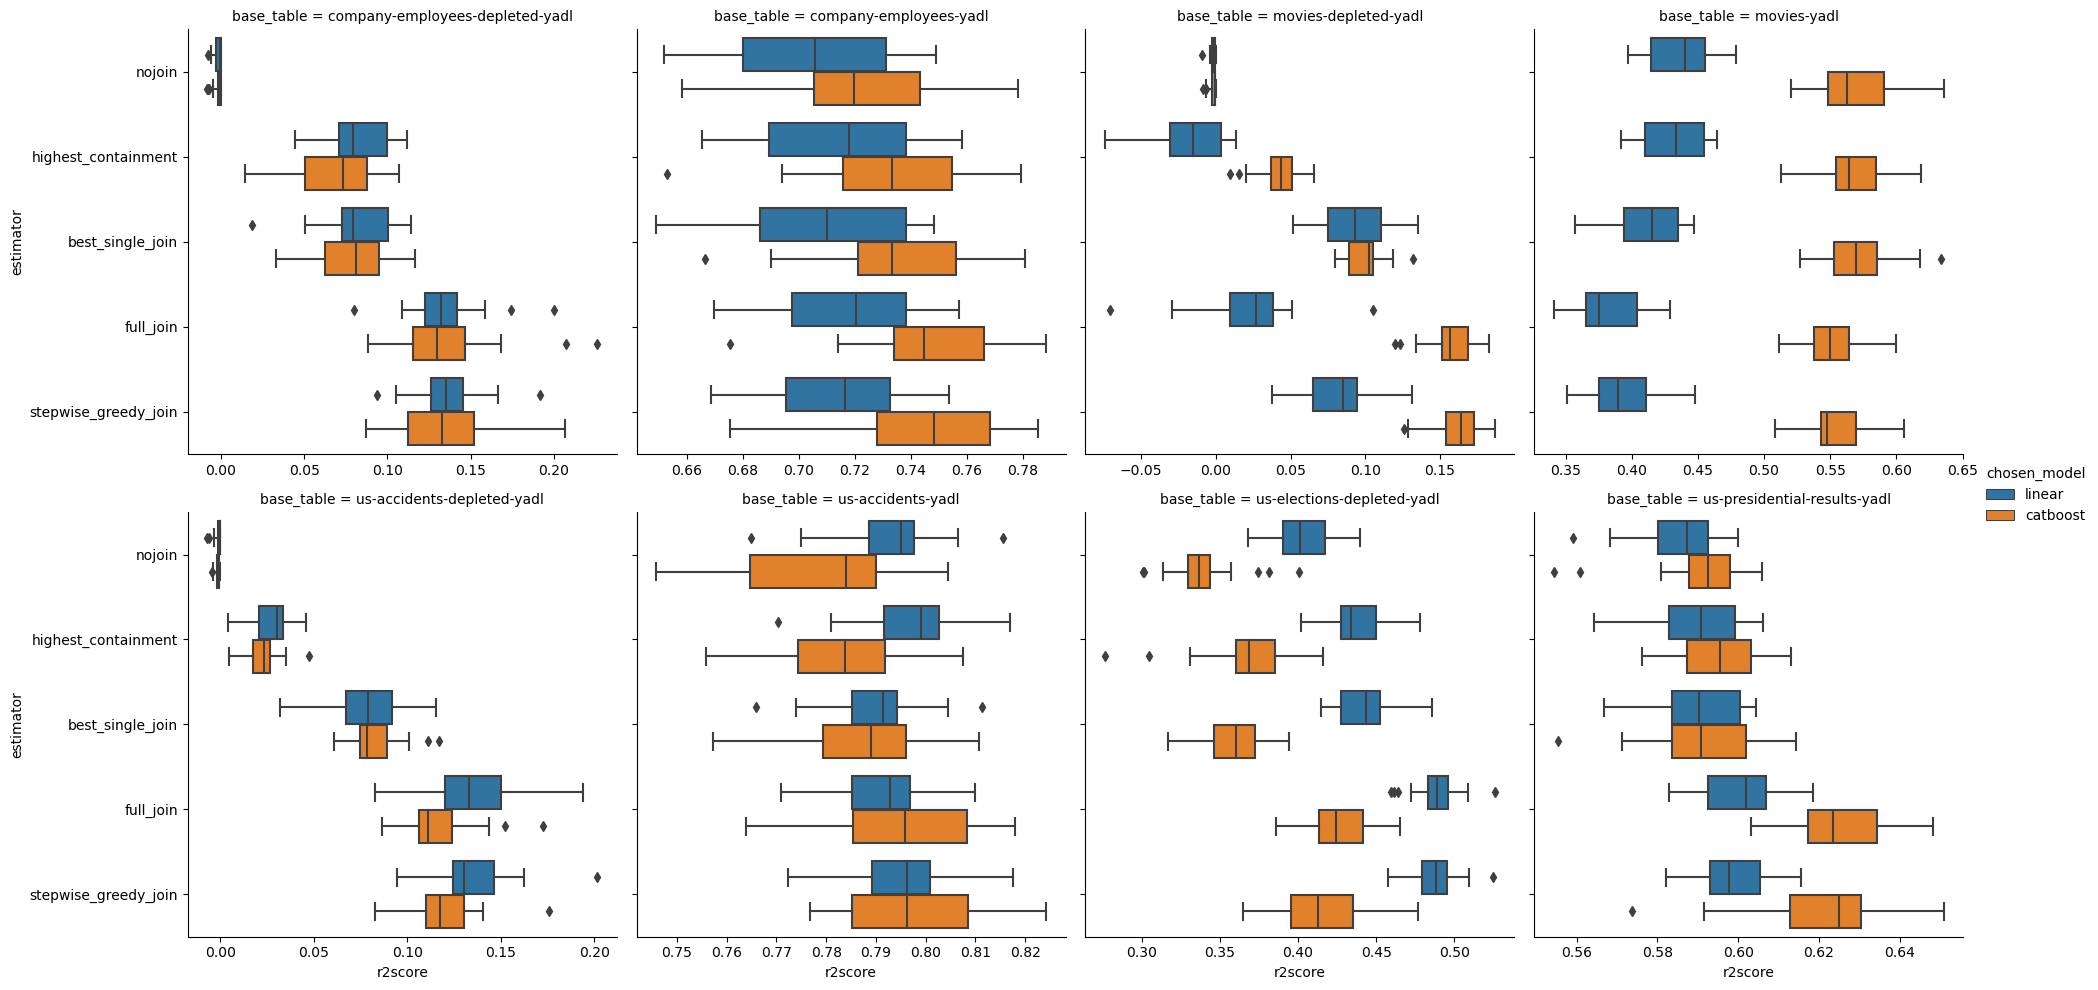

In [12]:
sns.catplot(
    data=df_raw.to_pandas(),
    x="r2score",
    y="estimator",
    hue="chosen_model",
    kind="box",
    col="base_table",
    sharex=False,
    col_wrap=col_wrap,
    col_order=col_order,
)

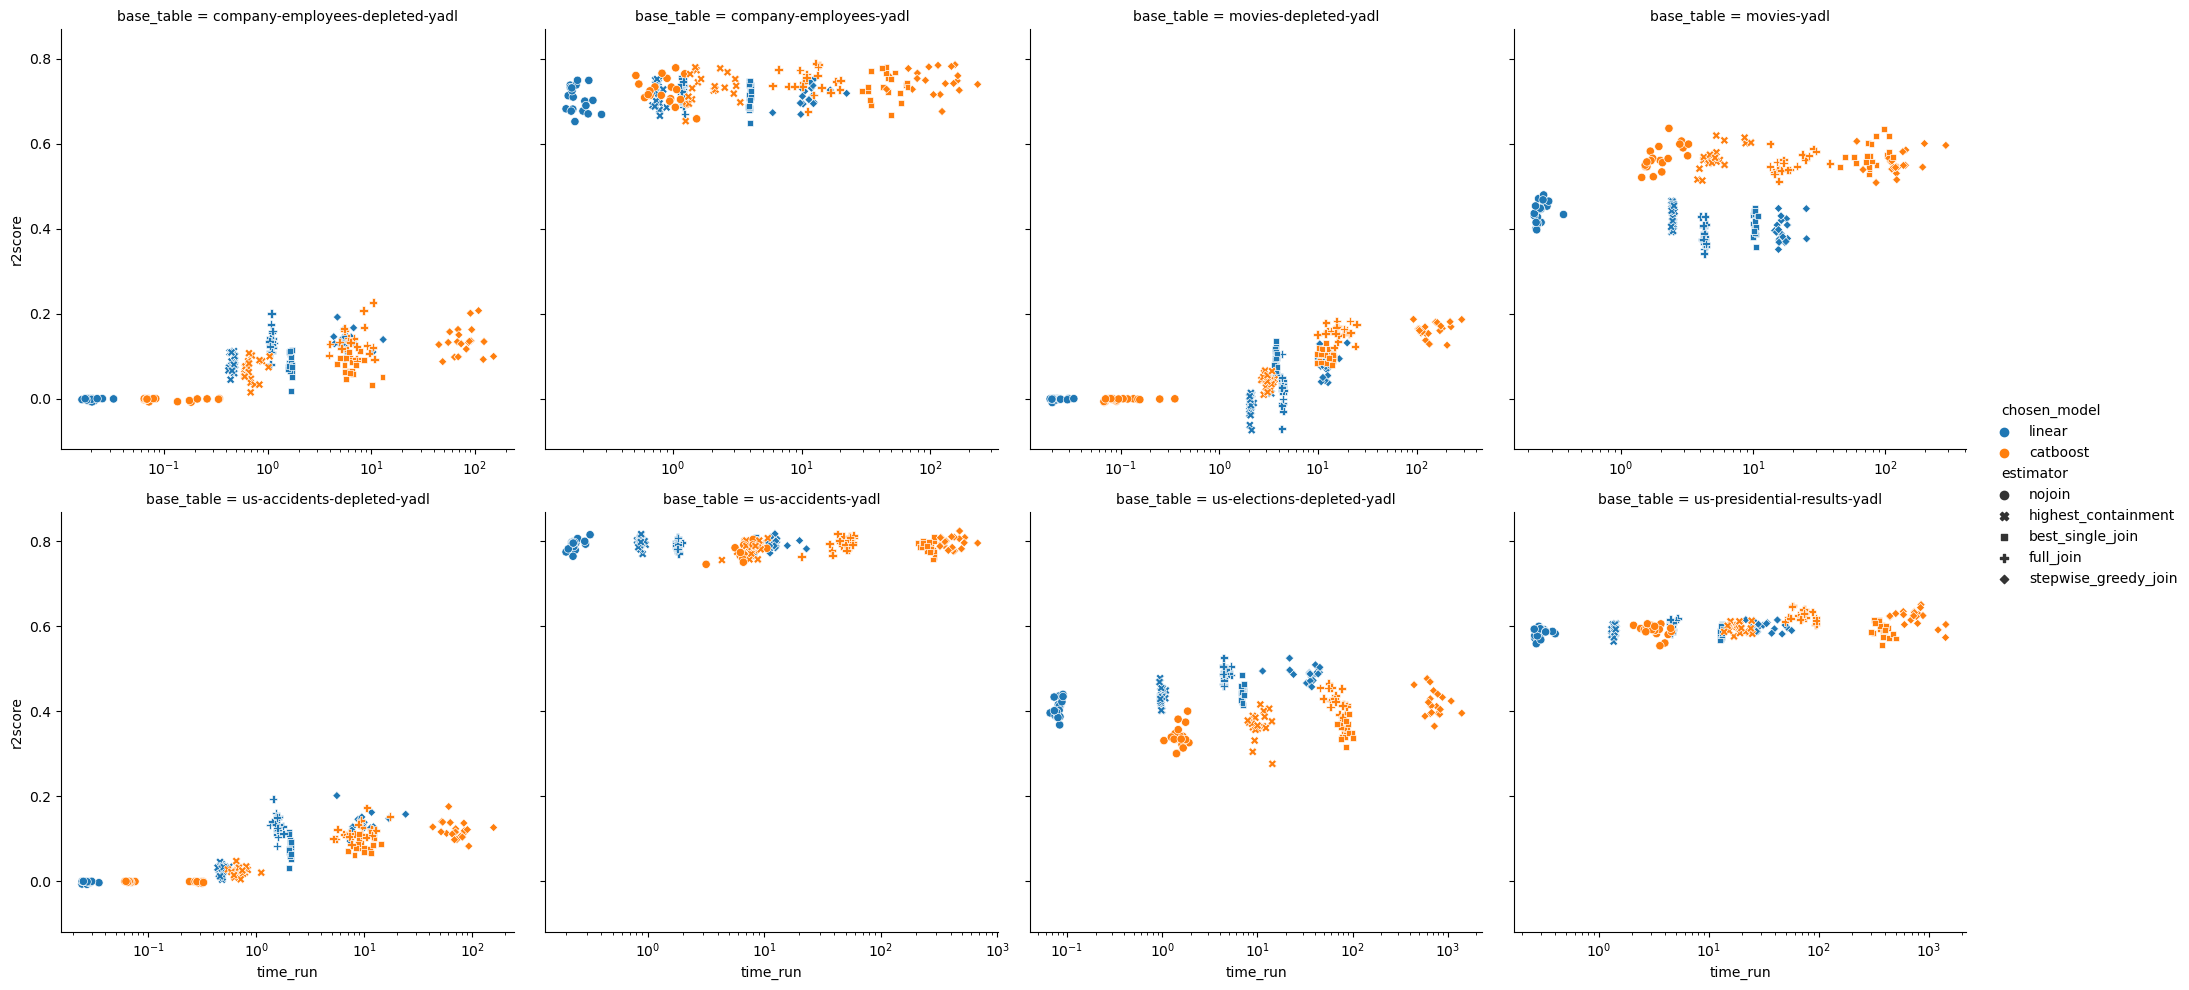

In [13]:
sns.relplot(
    data=df_raw.to_pandas(),
    x="time_run",
    y="r2score",
    hue="chosen_model",
    col="base_table",
    style="estimator",
    kind="scatter",
    facet_kws={"sharex": False, "sharey": True, "subplot_kws": {"xscale": "log"}},
    col_wrap=col_wrap,
    col_order=col_order,
)

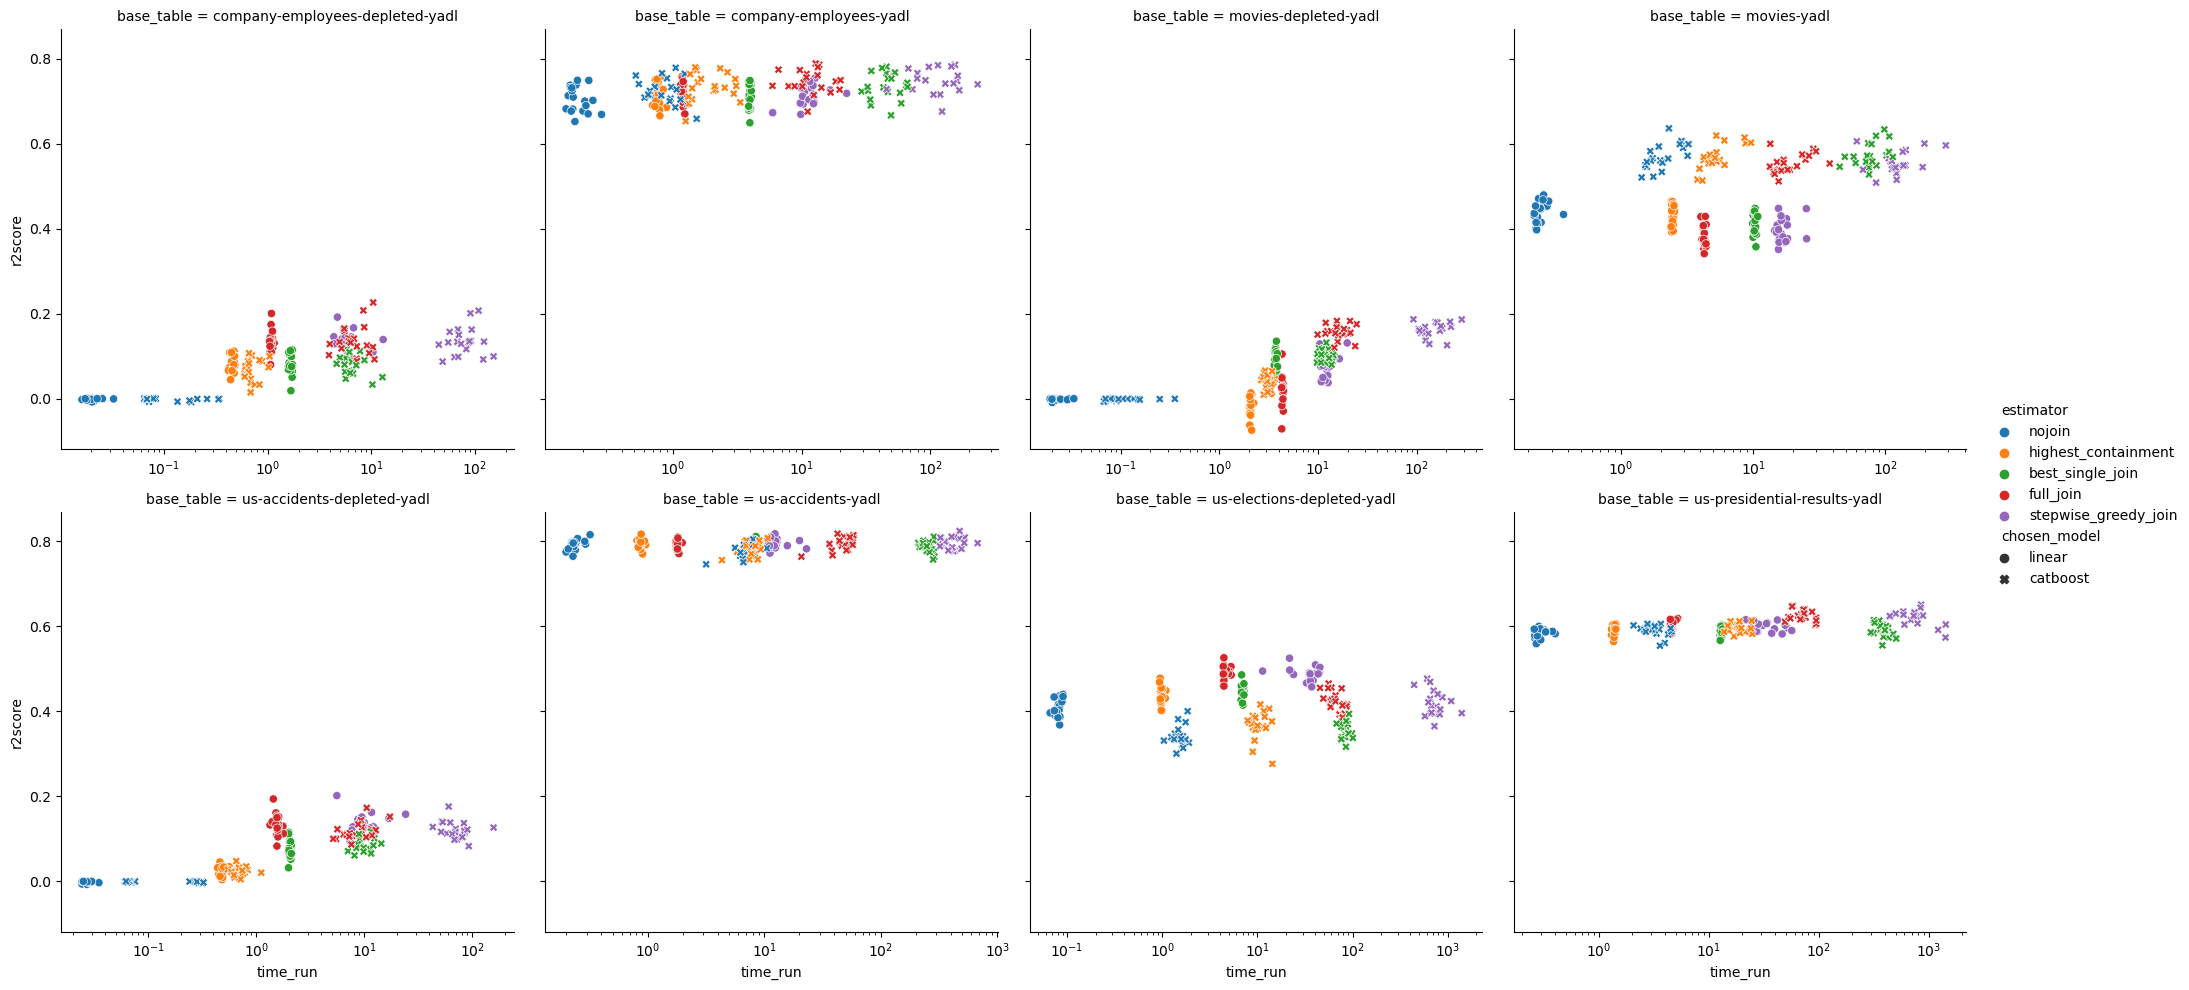

In [14]:
sns.relplot(
    data=df_raw.to_pandas(),
    x="time_run",
    y="r2score",
    style="chosen_model",
    col="base_table",
    hue="estimator",
    kind="scatter",
    facet_kws={"sharex": False, "sharey": True, "subplot_kws": {"xscale": "log"}},
    col_wrap=col_wrap,
    col_order=col_order,
)

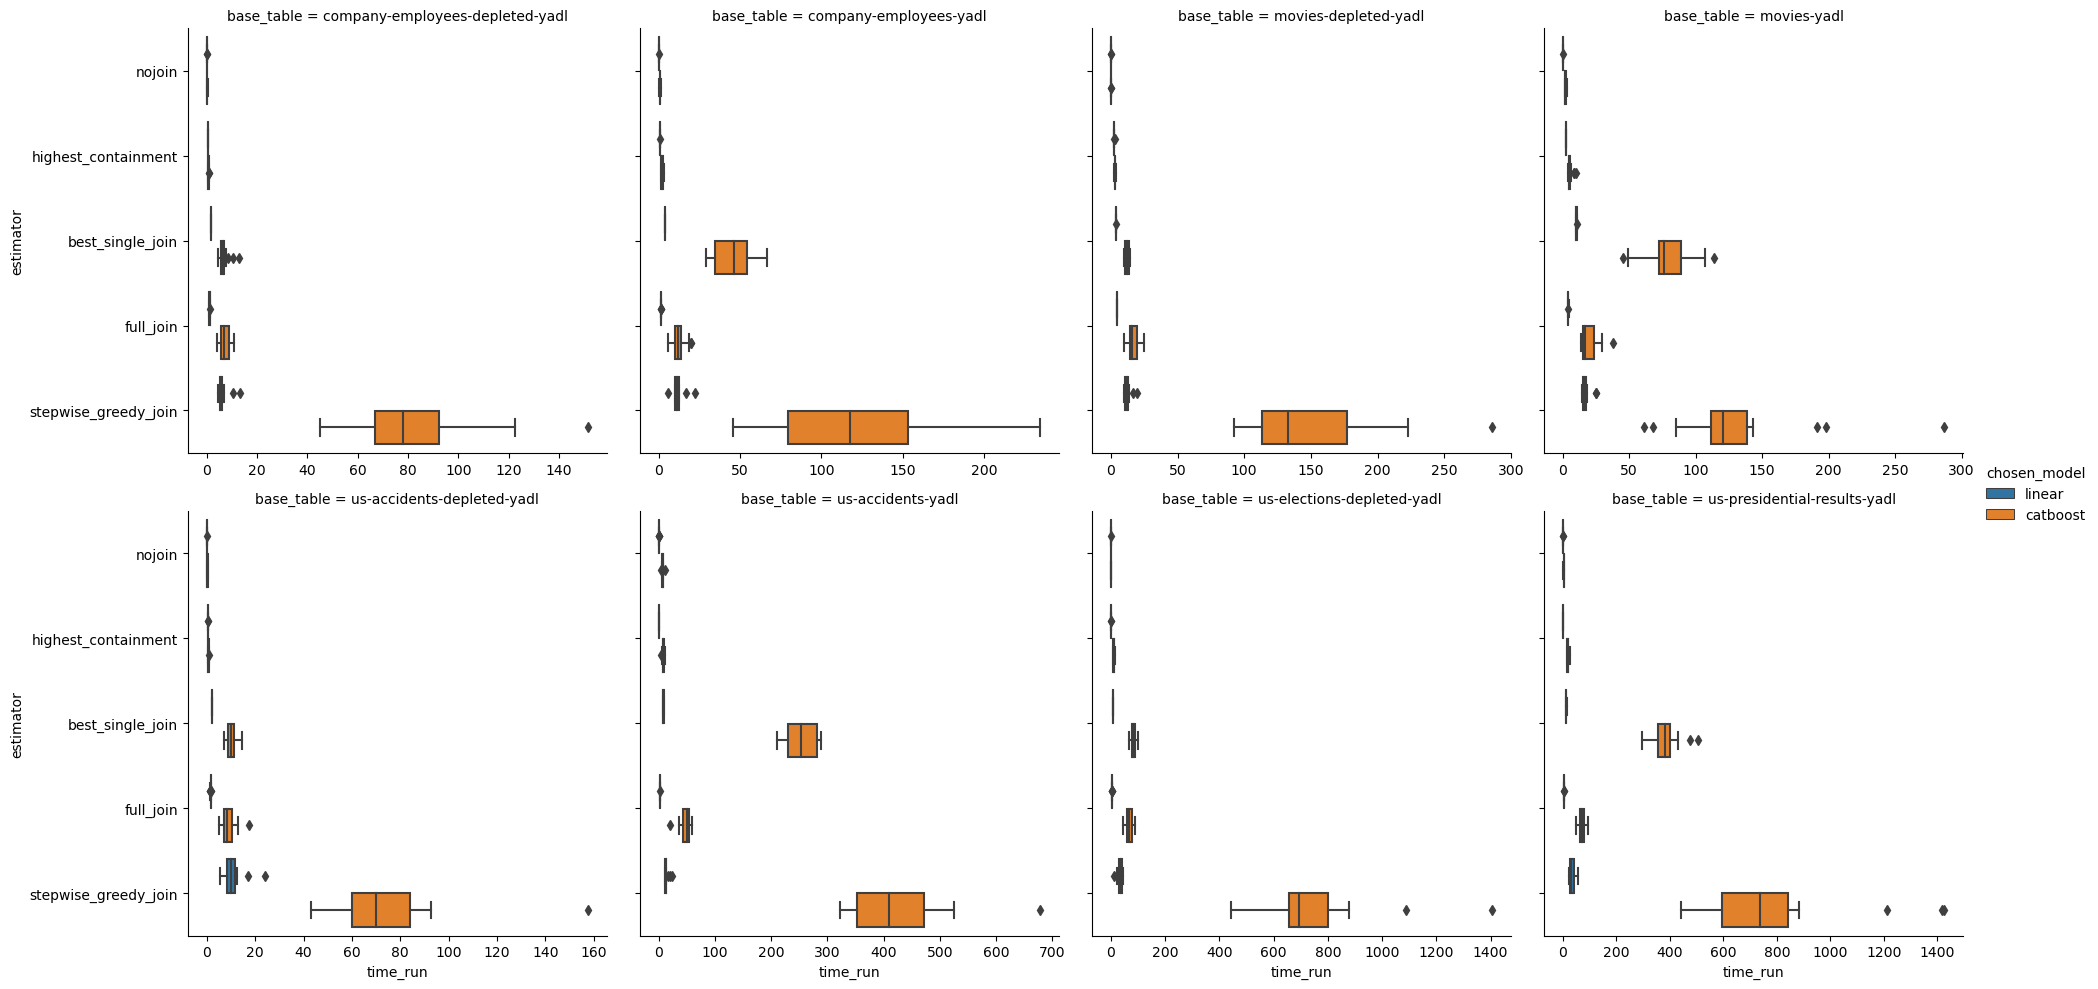

In [15]:
sns.catplot(
    data=df_raw.to_pandas(),
    x="time_run",
    y="estimator",
    hue="chosen_model",
    kind="box",
    col="base_table",
    sharex=False,
    col_wrap=col_wrap,
    col_order=col_order,
)

In [16]:
df_ = df_raw.groupby(["base_table", "estimator", "chosen_model"]).agg(
    pl.mean("r2score").alias("avg_r2"),
    pl.std("r2score").alias("std_r2"),
)

# Stepwise with epsilon

In [17]:
run_name = "0214-75ep48fi"
run_name = "0217-hzapevw7"
run_path = None

In [18]:
df_raw = read_logs(exp_name=run_name, exp_path=run_path)
df_raw = df_raw.with_columns(
    pl.col("epsilon").cast(pl.Utf8)
)


In [20]:
# df_raw = df_raw.with_columns(
#     pl.when(pl.col("right_on").is_null())
#     .then(pl.col("estimator"))
#     .otherwise(pl.col("estimator") + " " + pl.col("right_on").cast(pl.Utf8))
#     .alias("epsilon")
# )

In [21]:
df_ = df_raw.select(
    pl.col(
        [
            "scenario_id",
            "base_table",
            "estimator",
            "chosen_model",
            "aggregation",
            "r2score",
            "time_fit",
            "time_predict",
            "time_run",
            "epsilon",
        ]
    )
)

In [22]:
col_order = (
    df_raw.select(pl.col("base_table").unique())
    .sort("base_table")
    .to_series()
    .to_list()
)
col_wrap = 2

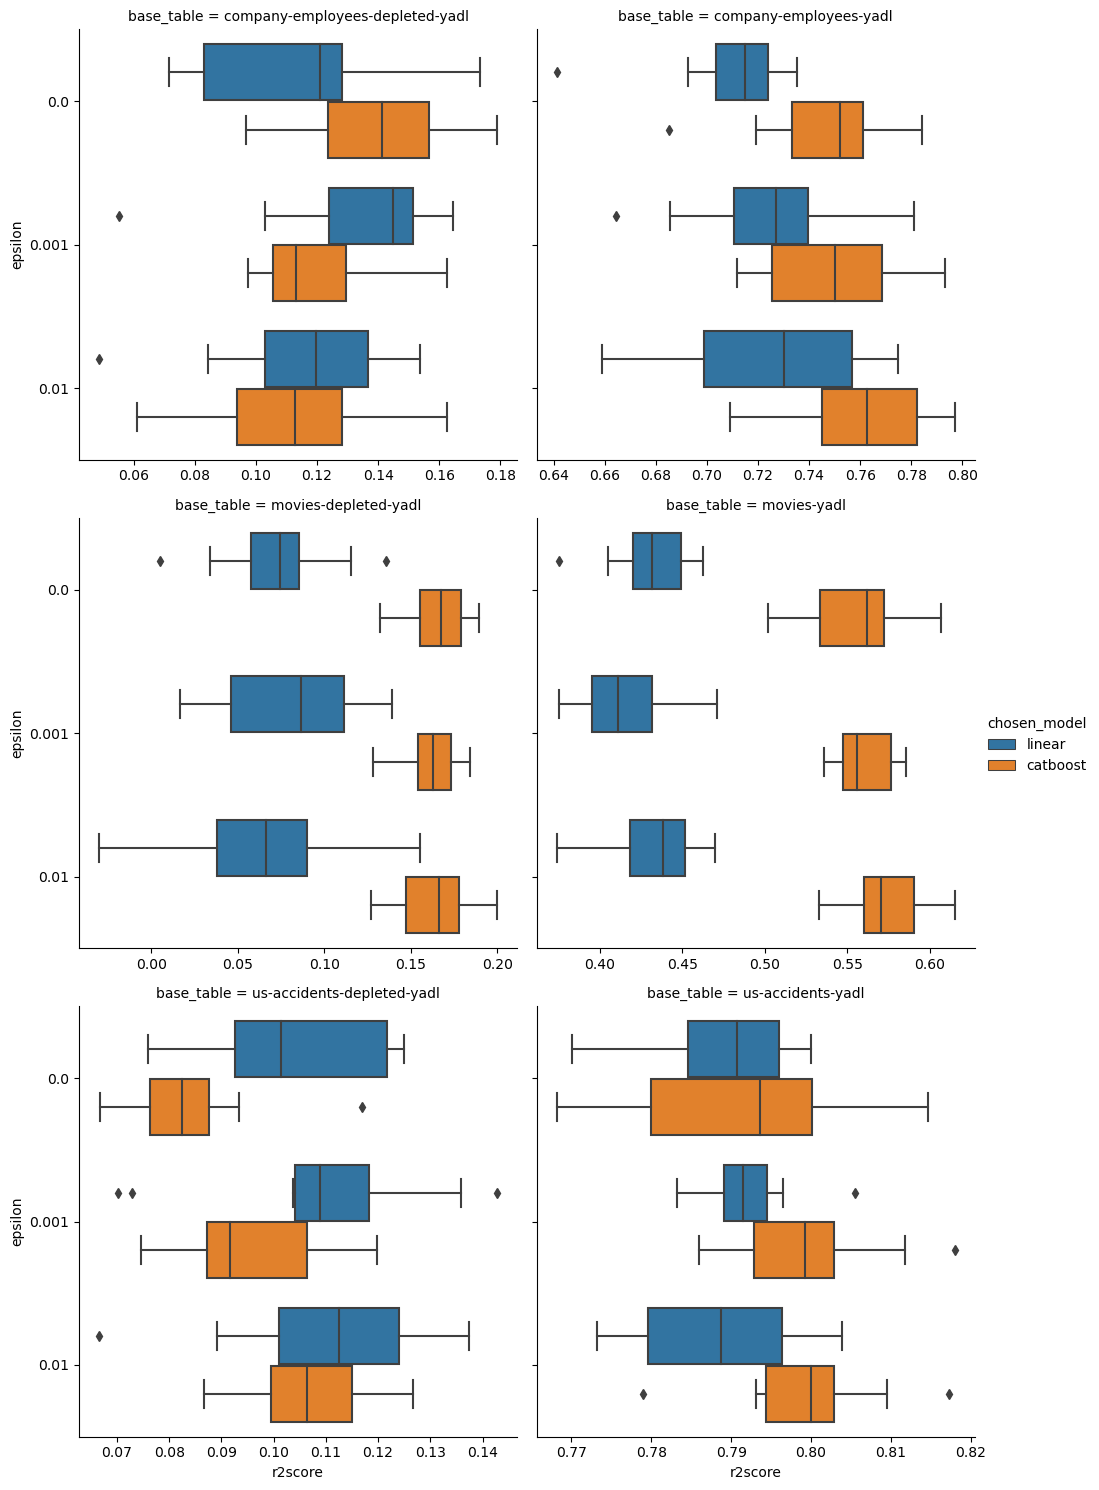

In [23]:
sns.catplot(
    data=df_raw.to_pandas(),
    x="r2score",
    y="epsilon",
    hue="chosen_model",
    kind="box",
    col="base_table",
    sharex=False,
    col_wrap=col_wrap,
    col_order=col_order,
)

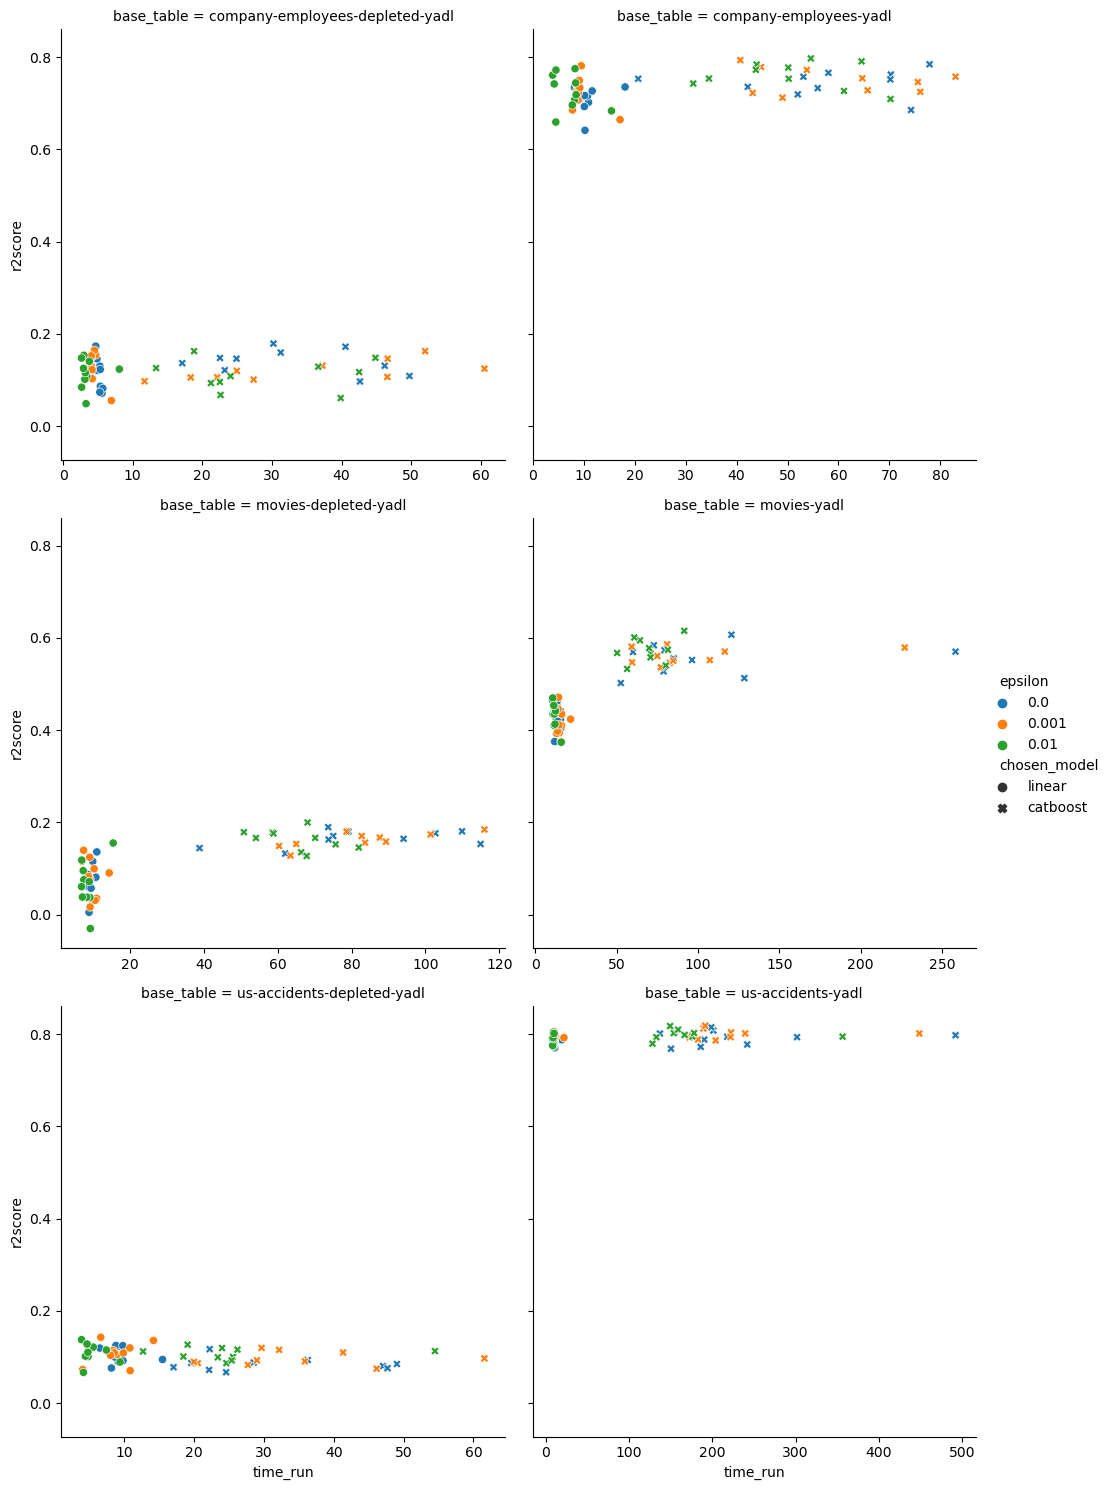

In [24]:
sns.relplot(
    data=df_raw.to_pandas(),
    x="time_run",
    y="r2score",
    hue="epsilon",
    col="base_table",
    style="chosen_model",
    kind="scatter",
    facet_kws={"sharex": False, "sharey": True, "subplot_kws": {"xscale": "linear"}},
    col_wrap=col_wrap,
    col_order=col_order,
)

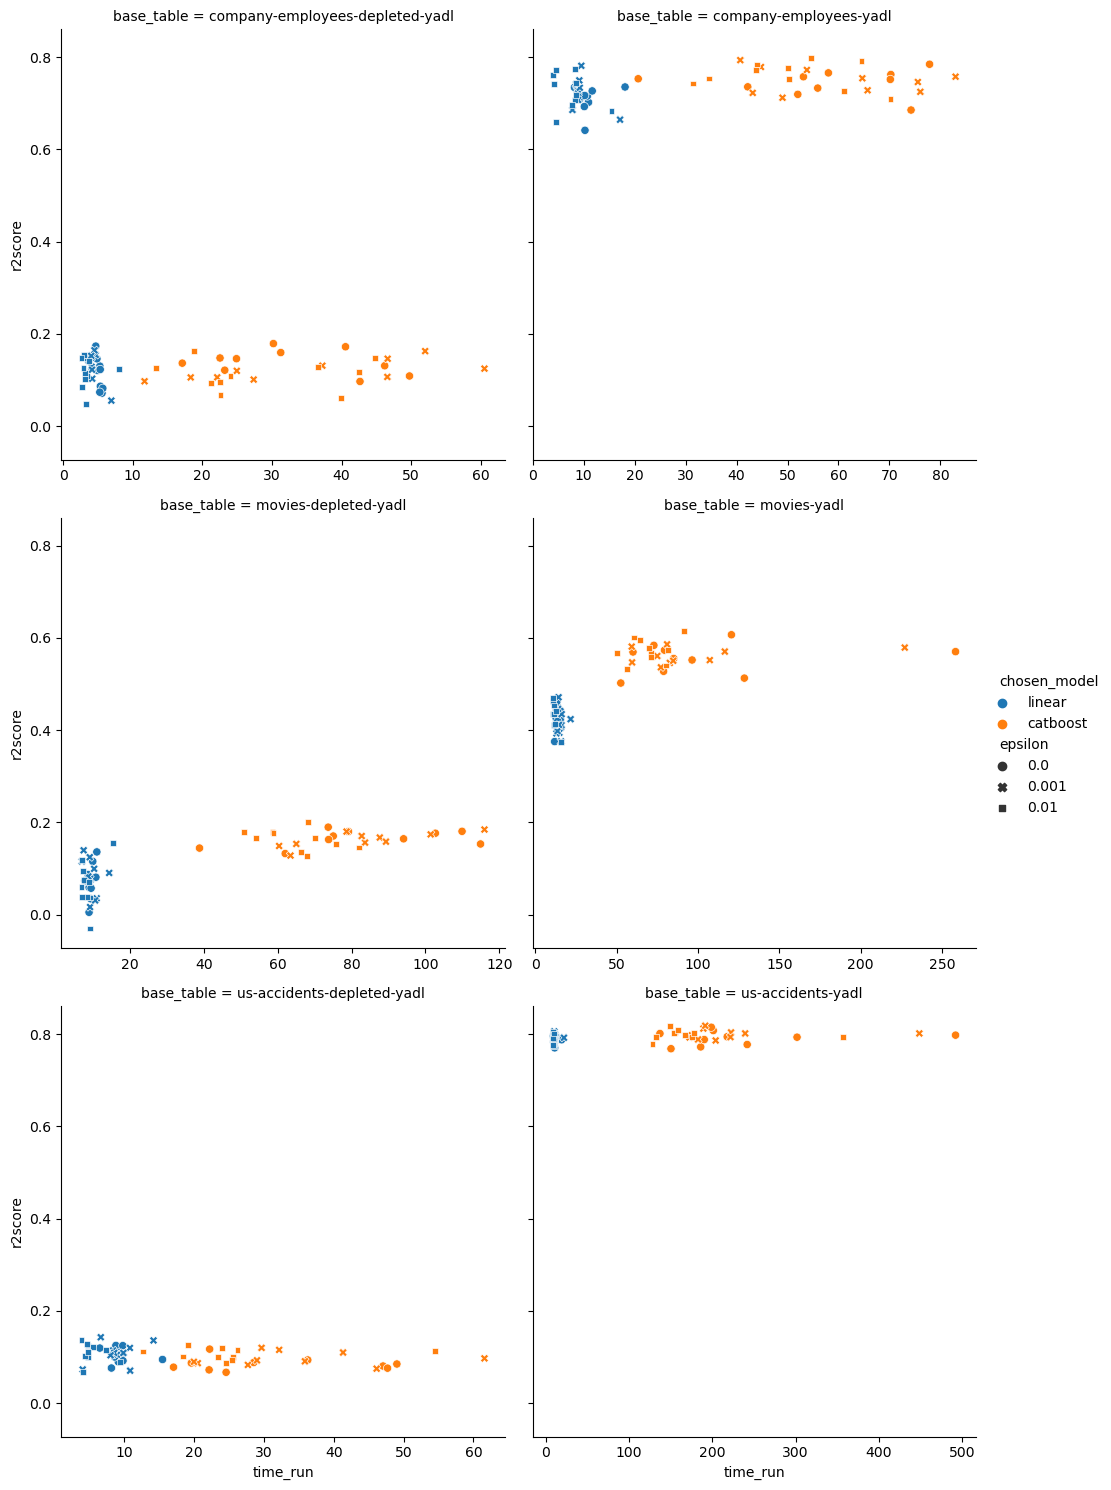

In [25]:
sns.relplot(
    data=df_raw.to_pandas(),
    x="time_run",
    y="r2score",
    hue="chosen_model",
    col="base_table",
    style="epsilon",
    kind="scatter",
    facet_kws={"sharex": False, "sharey": True, "subplot_kws": {"xscale": "linear"}},
    col_wrap=col_wrap,
    col_order=col_order,
)

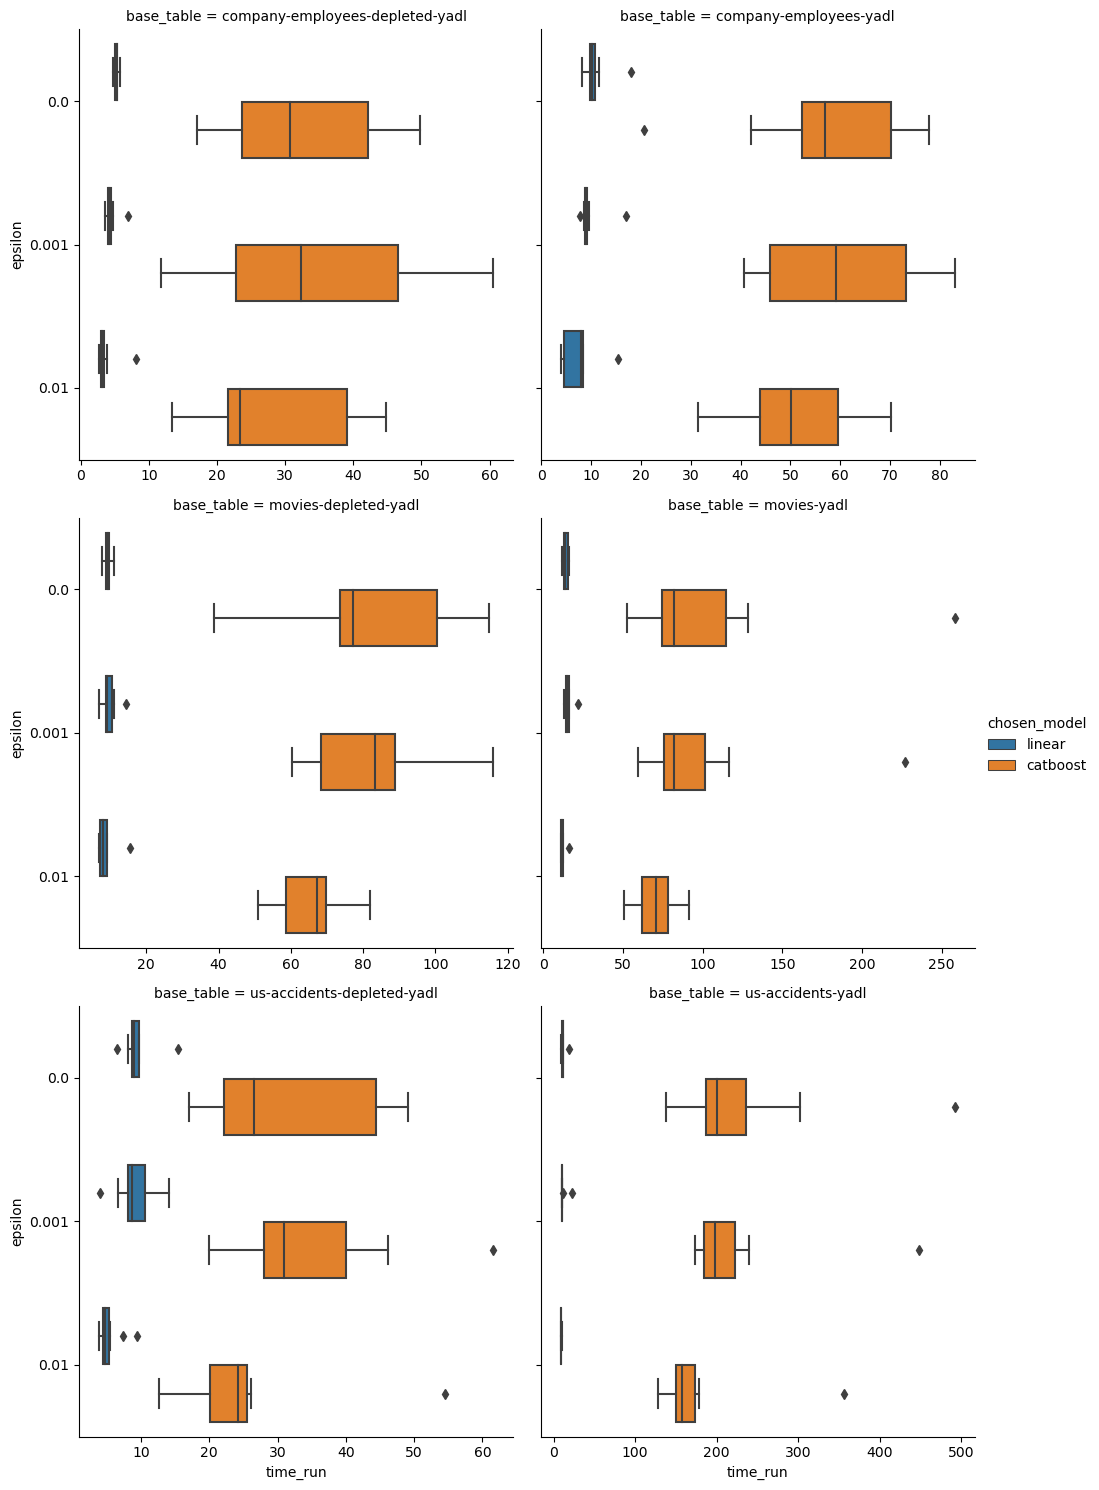

In [26]:
sns.catplot(
    data=df_raw.to_pandas(),
    x="time_run",
    y="epsilon",
    hue="chosen_model",
    kind="box",
    col="base_table",
    sharex=False,
    col_wrap=col_wrap,
    col_order=col_order,
)

In [27]:
subset = df_raw.filter(
    (pl.col("base_table") == "movies-depleted-yadl")
    & (pl.col("chosen_model") == "catboost")
    & (pl.col("estimator") != "nojoin")
)

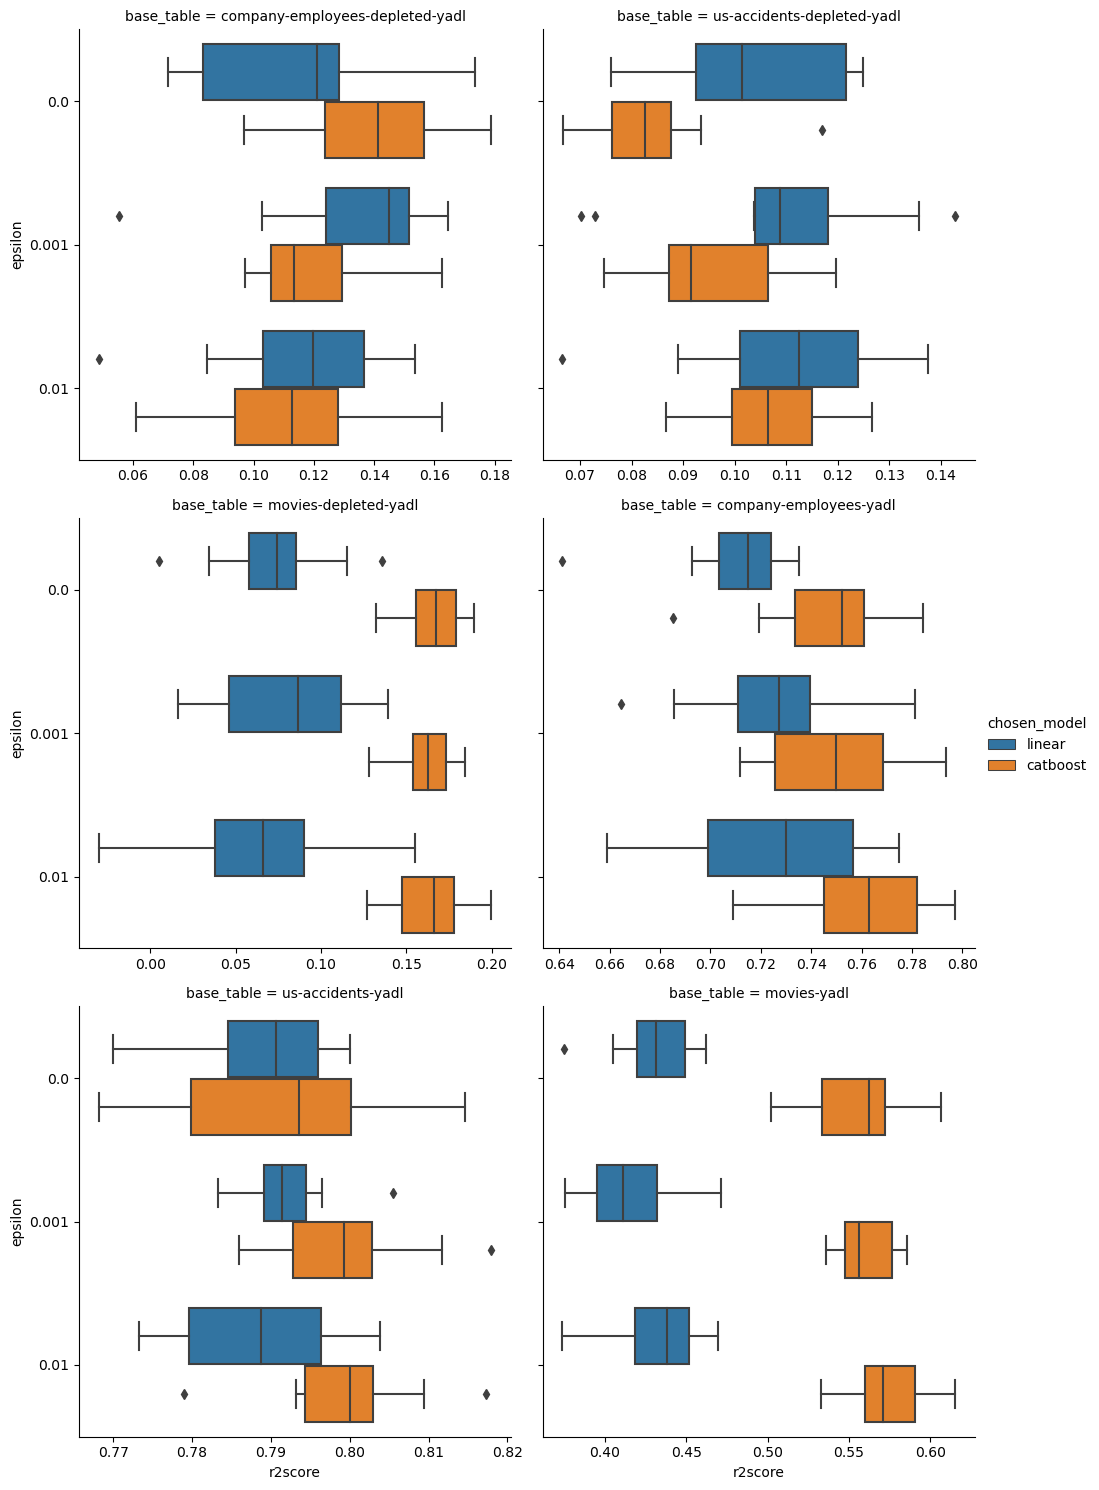

In [28]:
sns.catplot(
    data=df_raw.filter(pl.col("estimator") == "stepwise_greedy_join").to_pandas(),
    x="r2score",
    y="epsilon",
    hue="chosen_model",
    col="base_table",
    col_wrap=col_wrap,
    kind="box",
    sharex=False,
)

# Comparing fixed epsilon with scaled epsilon
Fixed `epsilon` means that it does not evolve during the course of the execution.

Scaled `epsilon` decreases over the course of the execution following an exponential curve. 

In [31]:
fixed_epsilon_run = "0214-75ep48fi"

scaled_epsilon_run = "0217-hzapevw7"
run_path = None

In [44]:
df_fixed = read_logs(exp_name=fixed_epsilon_run, exp_path=run_path)
df_fixed = df_fixed.with_columns(
    pl.when(pl.col("right_on").is_null())
    .then(pl.col("estimator"))
    .otherwise("fixed_eps" + " " + pl.col("right_on").cast(pl.Utf8))
    .alias("epsilon")
)
df_fixed = df_fixed.with_columns(
    pl.col("epsilon").cast(pl.Utf8)
)
df_fixed = df_fixed.with_columns(
    pl.when(pl.col("estimator") == "stepwise_greedy_join").then("fixed_eps").otherwise("no_eps").alias("eps_case")
)

df_scaled = read_logs(exp_name=scaled_epsilon_run, exp_path=run_path)
df_scaled = df_scaled.with_columns(
    ("scaled_eps " + pl.col("epsilon").cast(pl.Utf8)).alias("epsilon"),
    pl.lit("scaled_eps").alias("eps_case")
)


In [48]:
selected_columns = [
    "base_table", "estimator", "chosen_model", "time_run", "r2score", "epsilon", "eps_case"
]
df_concat = pl.concat([df_fixed.select(selected_columns), df_scaled.select(selected_columns)])

In [49]:
df_concat

base_table,estimator,chosen_model,time_run,r2score,epsilon,eps_case
str,str,str,f64,f64,str,str
"""company-employees-depleted-yadl""","""nojoin""","""linear""",0.023004,-0.002887,"""nojoin""","""no_eps"""
"""company-employees-depleted-yadl""","""full_join""","""linear""",1.557585,0.051675,"""full_join""","""no_eps"""
"""company-employees-depleted-yadl""","""stepwise_greedy_join""","""linear""",6.004421,0.070835,"""fixed_eps 0.0""","""fixed_eps"""
"""company-employees-depleted-yadl""","""nojoin""","""linear""",0.01846,-0.001134,"""nojoin""","""no_eps"""
"""company-employees-depleted-yadl""","""full_join""","""linear""",1.271227,0.110139,"""full_join""","""no_eps"""
"""company-employees-depleted-yadl""","""stepwise_greedy_join""","""linear""",3.427326,0.122966,"""fixed_eps 0.0""","""fixed_eps"""
"""company-employees-depleted-yadl""","""nojoin""","""linear""",0.02044,-0.000003,"""nojoin""","""no_eps"""
"""company-employees-depleted-yadl""","""full_join""","""linear""",1.449881,0.089716,"""full_join""","""no_eps"""
"""company-employees-depleted-yadl""","""stepwise_greedy_join""","""linear""",4.040302,0.096073,"""fixed_eps 0.0""","""fixed_eps"""


In [50]:
col_order = (
    df_raw.select(pl.col("base_table").unique())
    .sort("base_table")
    .to_series()
    .to_list()
)
col_wrap = 2

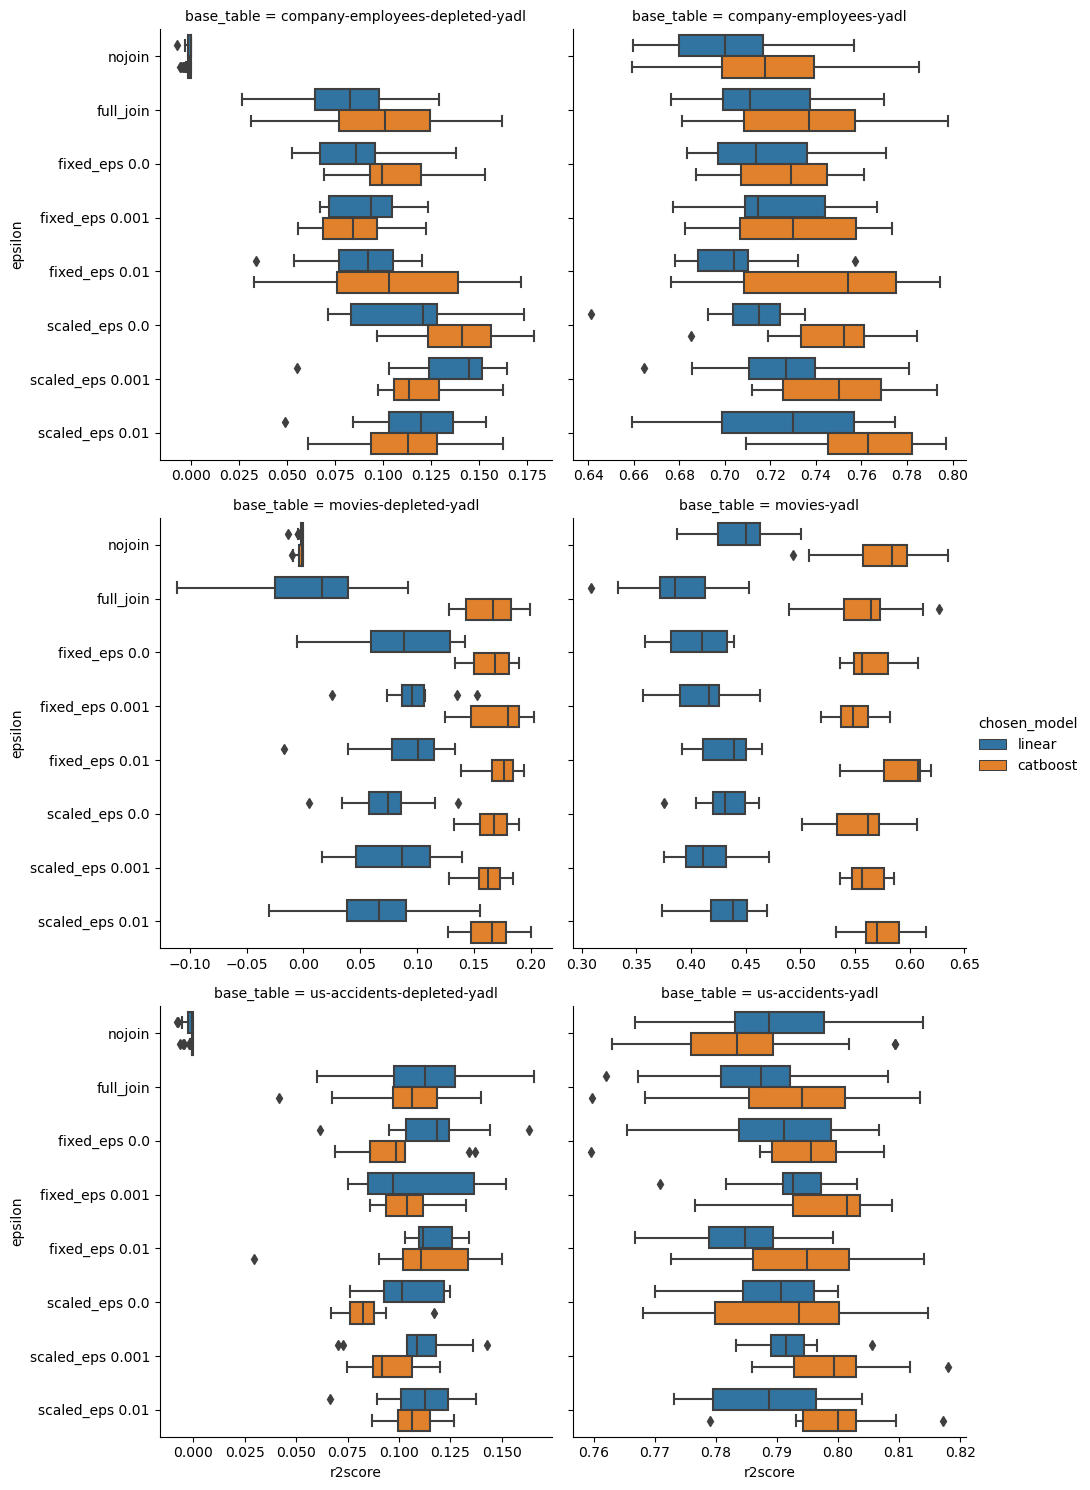

In [52]:
sns.catplot(
    data=df_concat.to_pandas(),
    x="r2score",
    y="epsilon",
    hue="chosen_model",
    kind="box",
    col="base_table",
    sharex=False,
    col_wrap=col_wrap,
    col_order=col_order,
)

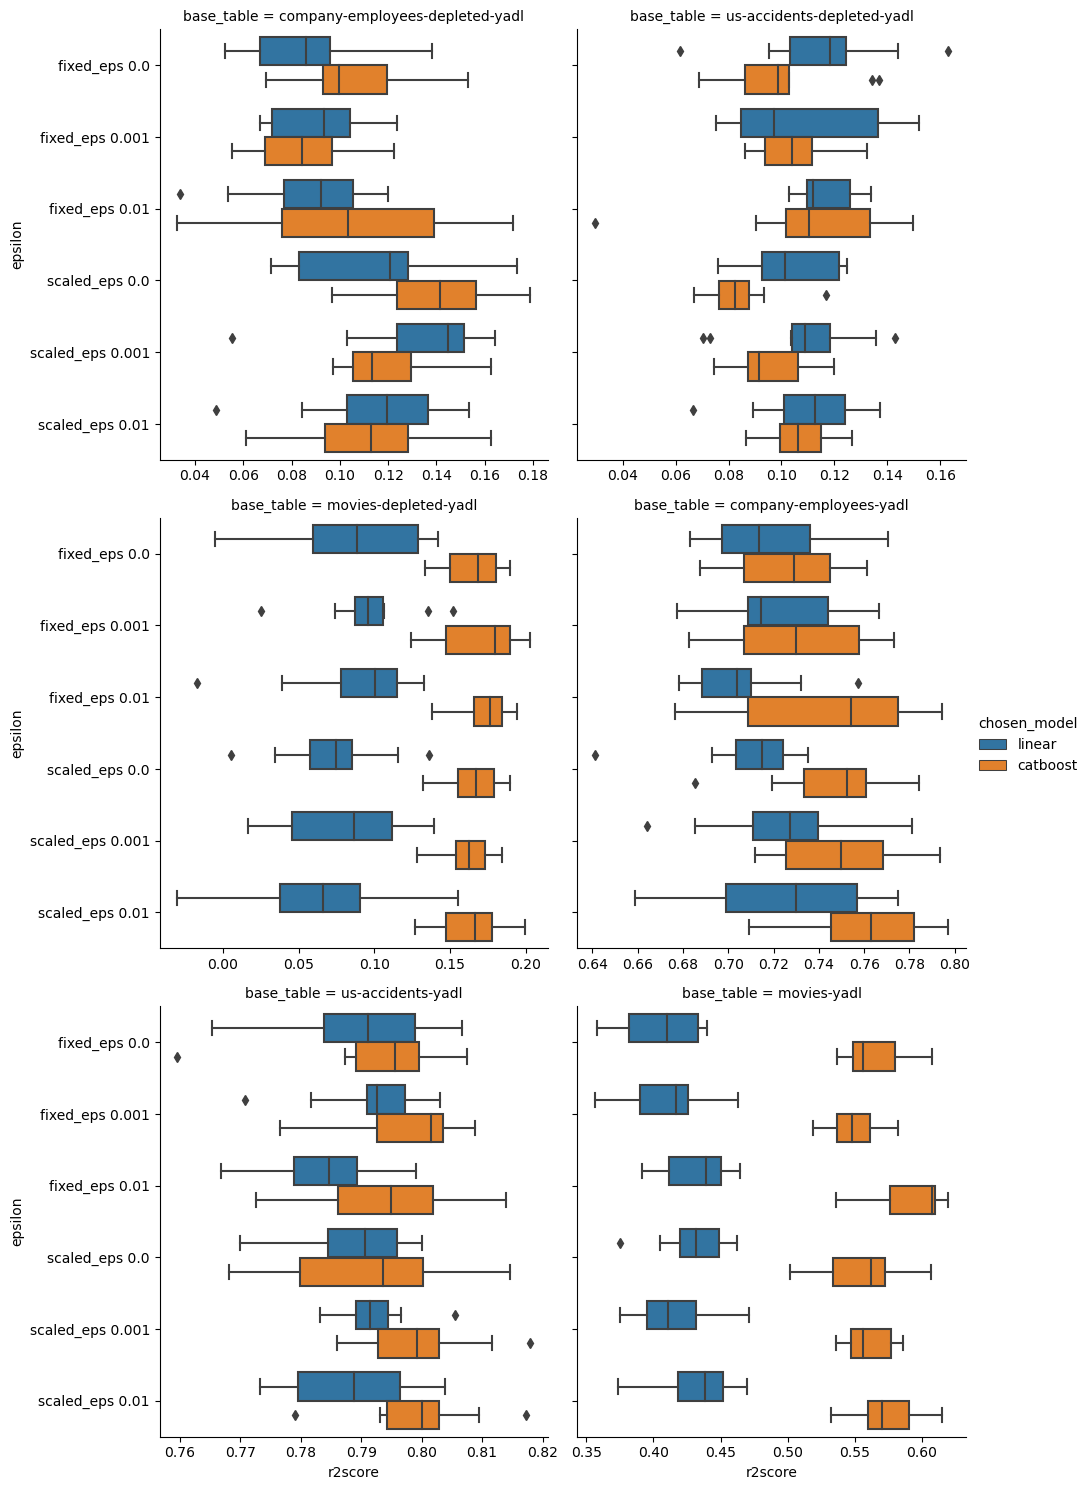

In [57]:
sns.catplot(
    data=df_concat.filter((pl.col("estimator") == "stepwise_greedy_join") ).to_pandas(),
    x="r2score",
    y="epsilon",
    hue="chosen_model",
    col="base_table",
    col_wrap=col_wrap,
    kind="box",
    sharex=False,
)

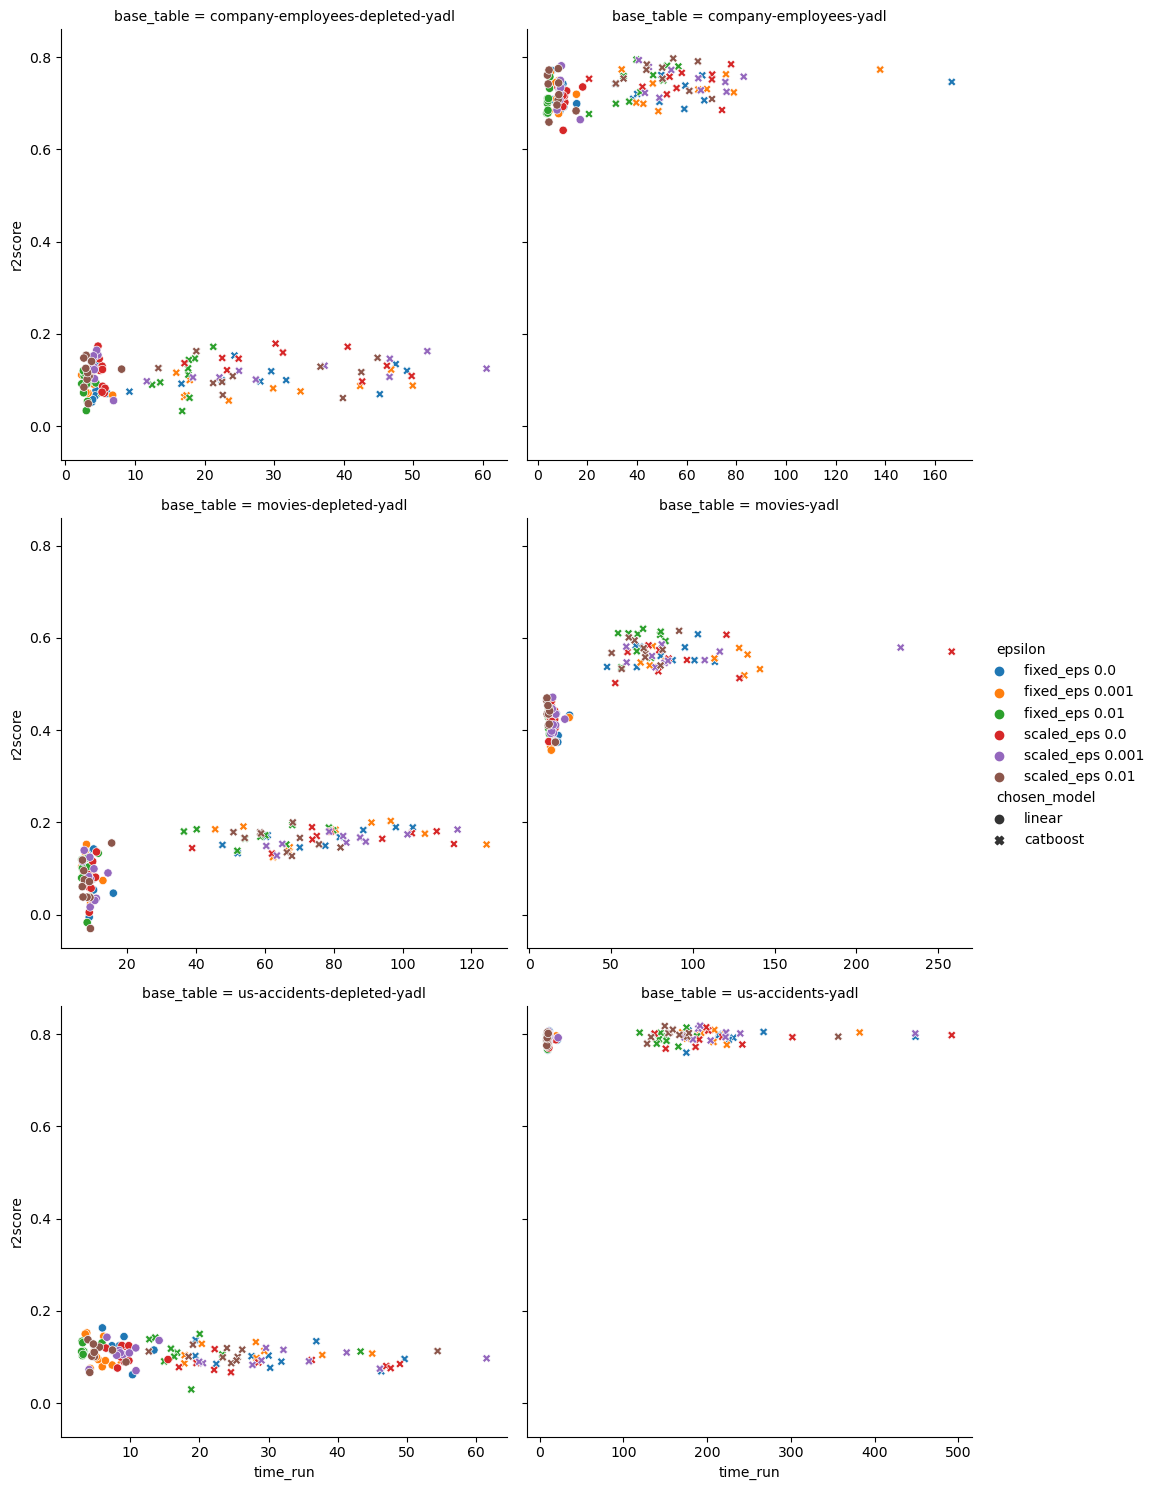

In [64]:
sns.relplot(
    data=df_concat.filter((pl.col("estimator") == "stepwise_greedy_join")).to_pandas(),
    x="time_run",
    y="r2score",
    hue="epsilon",
    col="base_table",
    style="chosen_model",
    kind="scatter",
    facet_kws={"sharex": False, "sharey": True, "subplot_kws": {"xscale": "linear"}},
    col_wrap=col_wrap,
    col_order=col_order,
)

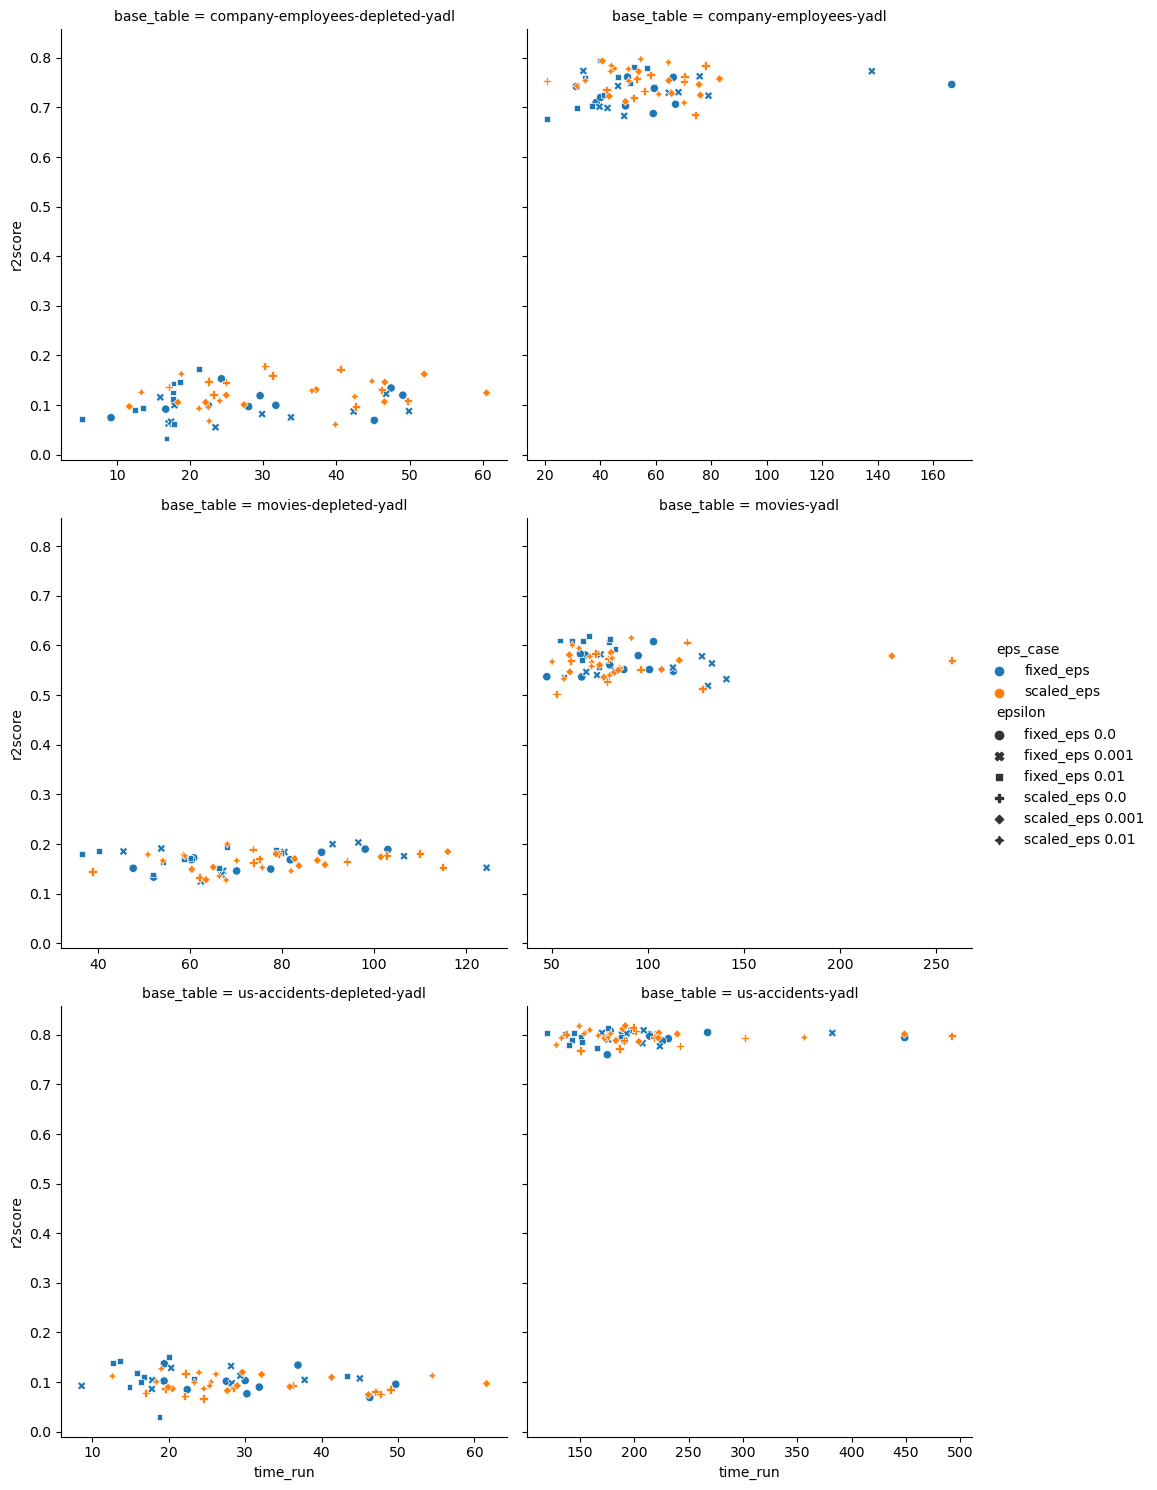

In [71]:
sns.relplot(
    data=df_concat.filter(
        (pl.col("chosen_model") == "catboost") & 
        (pl.col("estimator") == "stepwise_greedy_join") 
        
        ).to_pandas(),
    x="time_run",
    y="r2score",
    style="epsilon",
    col="base_table",
    hue="eps_case",
    kind="scatter",
    facet_kws={"sharex": False, "sharey": True, "subplot_kws": {"xscale": "linear"}},
    col_wrap=col_wrap,
    col_order=col_order,
)

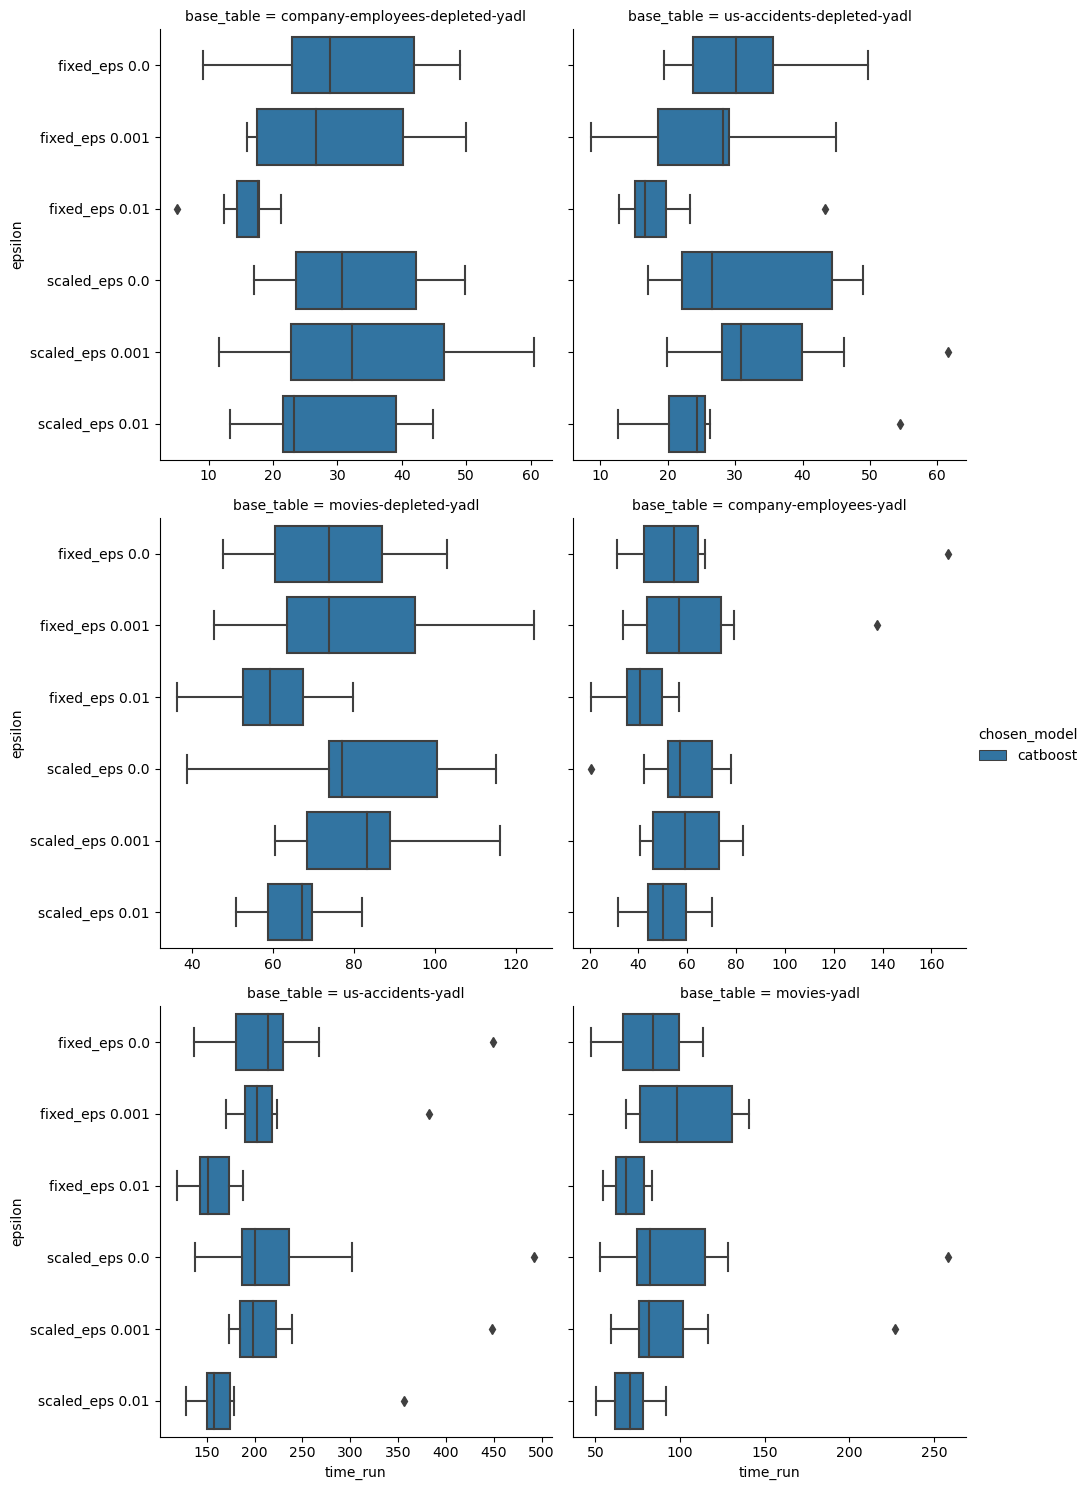

In [79]:
sns.catplot(
    data=df_concat.filter(
        (pl.col("estimator") == "stepwise_greedy_join") &
        (pl.col("chosen_model") == "catboost") 
        ).to_pandas(),
    x="time_run",
    y="epsilon",
    hue="chosen_model",
    col="base_table",
    col_wrap=col_wrap,
    kind="box",
    sharex=False,
)